In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score
from sklearn import metrics

In [23]:
df_cct = pd.read_parquet("/home/onyxia/work/df_cct_stand2.parquet")

### Correlation map

<Axes: >

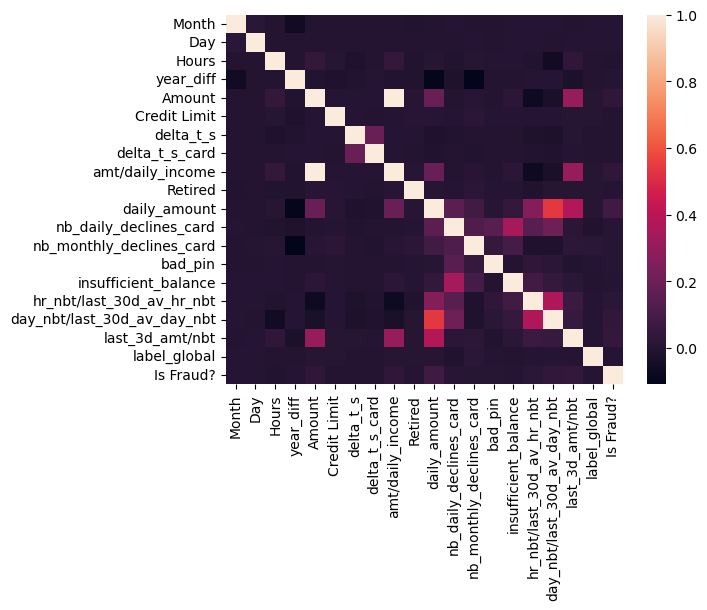

In [3]:
sns.heatmap(df_cct[['Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'label_global',
       'Is Fraud?']].corr())

In [3]:
df_cct.columns

Index(['User', 'Card', 'Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Use Chip', 'Card Brand', 'Card Type', 'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'label_global',
       'Is Fraud?'],
      dtype='object')

### Preprocessing (code to create standarized (by User) dataset) - DO NOT RUN

In [19]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num = df_cct.loc[:,~df_cct.columns.isin(["User","Card","label_global","Retired", "bad_pin", "insufficient_balance","Is Fraud?"])].select_dtypes(include=numerics).columns.to_list()
cat = df_cct.select_dtypes(include=['object']).columns.to_list()


In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df = pd.DataFrame()
for i in range(2000):
    user_i = df_cct[df_cct["User"] == i]
    user_i[num] = scaler.fit_transform(user_i[num])
    df = pd.concat([df,user_i], axis=0)


In [51]:
#df.to_parquet("/home/onyxia/work/df_cct_stand2.parquet")

### Encode categorical variables

In [24]:
# Pour "Use Chip":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Use Chip"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [25]:
# Pour "Card Brand":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Card Brand"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [26]:
# Pour "Card Type"":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Card Type"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [6]:
df_cct.columns

Index(['User', 'Card', 'Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Use Chip', 'Card Brand', 'Card Type', 'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'label_global',
       'Is Fraud?', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction', 'Amex', 'Discover', 'Mastercard', 'Visa', 'Credit',
       'Debit', 'Debit (Prepaid)'],
      dtype='object')

### Manually create train/test datasets

In [27]:
# selecting features
# dropped card, nb_weekly_declines, day_of_week, nb_daily_declines, credit, debit, amex,  discover,
# mastercard, visa
features = ['Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction','Debit (Prepaid)',
        "label_global","Is Fraud?"]
df_selec = df_cct[features] # 21 features
X = df_selec[['Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction','Debit (Prepaid)']]
y = df_selec["Is Fraud?"]

In [28]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify = y)
df_trainval = df_selec.iloc[X_train_val.index]

In [29]:
df_cluster_stat = pd.DataFrame(columns = ["cluster", "count", "percentage_of_frauds"])
for i in range(-1, 7, 1):
    share = len(df_trainval[(df_trainval["label_global"] == i) & (df_trainval["Is Fraud?"] == 1)]) / len(df_trainval[df_trainval["label_global"] == i]) 
    df_cluster_stat.loc[len(df_cluster_stat)] = [i, len(df_trainval[df_trainval["label_global"] == i]),share]
df_cluster_stat["cluster"] = df_cluster_stat["cluster"].astype(int)

In [11]:
df_cluster_stat

,cluster,count,percentage_of_frauds
0,-1,102800.0,0.001089
1,0,17803706.0,0.001217
2,1,513628.0,0.001053
3,2,501117.0,0.001319
4,3,453143.0,0.001620
5,4,65702.0,0.000609
6,5,65701.0,0.000837
7,6,3723.0,0.000000


In [30]:
import random # manually creating train dataset (50% from each cluster)
# random sampling among each cluster created from DBSCAN work

random.seed(42)
df_train = pd.DataFrame()
for i in range(-1,7,1) :
    cluster_i_list = df_trainval[df_trainval["label_global"] == i].index.tolist()
    index = random.sample(cluster_i_list, int(0.5*len(df_trainval[df_trainval["label_global"] == i])))
    df_rs = df_trainval.loc[index]
    df_train = pd.concat([df_train, df_rs], axis = 0)

In [31]:
#X_train, y_train, contains around 12000 frauds
X_train = df_train.drop(["label_global","Is Fraud?"], axis = 1)
y_train = df_train["Is Fraud?"]

In [32]:
# retrieving frauds for later use
i_fraud = y_train[y_train.values == 1].index
X_train_fraud = X_train.loc[i_fraud]
i_no_fraud = y_train[y_train.values == 0].index
X_train_no_fraud = X_train.loc[i_no_fraud]

In [33]:
# test set : 55,000 rows, contains 5,000 frauds
df_rest = df_selec[~df_selec.index.isin(df_train.index)] # selecting the resting rows not taken for train set
df_rest_fraud = df_rest[df_rest["Is Fraud?"] == 1]
df_rest_no_fraud = df_rest[df_rest["Is Fraud?"] == 0]
df_val = pd.concat([df_rest_fraud.sample(5000, random_state = 42), df_rest_no_fraud.sample(50000, random_state = 42)], axis = 0)
df_val.sort_index(inplace=True)

In [34]:
X_val = df_val.drop(["label_global", "Is Fraud?"], axis = 1)
y_val = df_val["Is Fraud?"]

### Base - first model

In [35]:
# Build and train model without any hyperparameters
decision_tree = DecisionTreeClassifier(class_weight={1:0.9,0:0.1}, random_state=42)
decision_tree.fit(X_train, y_train)
print(decision_tree.tree_.max_depth)
# Apply model to validation data
y_pred_dt = decision_tree.predict(X_val)


46


Classification metrics: 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     50000
           1       0.93      0.15      0.25      5000

    accuracy                           0.92     55000
   macro avg       0.93      0.57      0.61     55000
weighted avg       0.92      0.92      0.89     55000



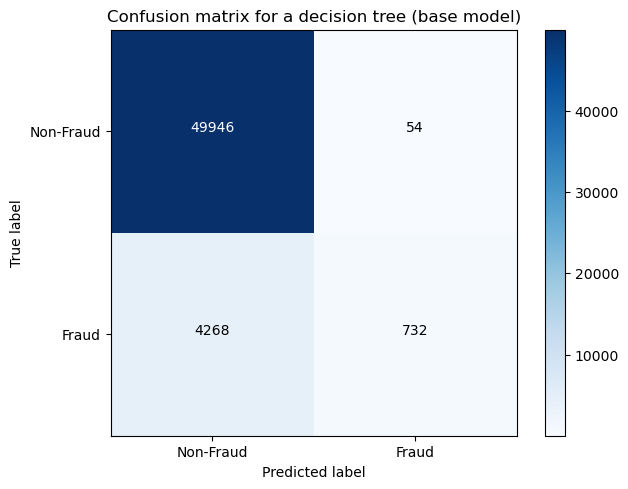

In [36]:
# Evaluate model
print('Classification metrics: \n', classification_report(y_val, y_pred_dt))
# plot confusion matrix function
import itertools

def plot_confusion_matrix(cm,normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        classes=['Non-Fraud','Fraud']
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=0)
        plt.yticks(tick_marks, classes)
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            # print("Normalized confusion matrix")
        else:
            1  # print('Confusion matrix, without normalization')

        # print(cm)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        return ()


cnf_matrix_dtree = confusion_matrix(y_val, y_pred_dt)
plt.figure()
plot_confusion_matrix(cnf_matrix_dtree, title='Confusion matrix for a decision tree (base model)')
plt.show()

In [48]:
# defining our own cost score
def our_score(y_test, y_pred) :
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    cost = 45*tp - 40*fn - 15*fp
    return cost

### SHAP values

In [25]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(decision_tree)

In [16]:
# selecting 15,000 frauds and 15,000 non frauds from train set
# otherwise, computation time is too big

X_train_shap = pd.concat([X_train_fraud, X_train_no_fraud.sample(len(X_train_fraud), random_state = 42)], axis = 0)

In [26]:
shap_values = explainer.shap_values(X_train_shap)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


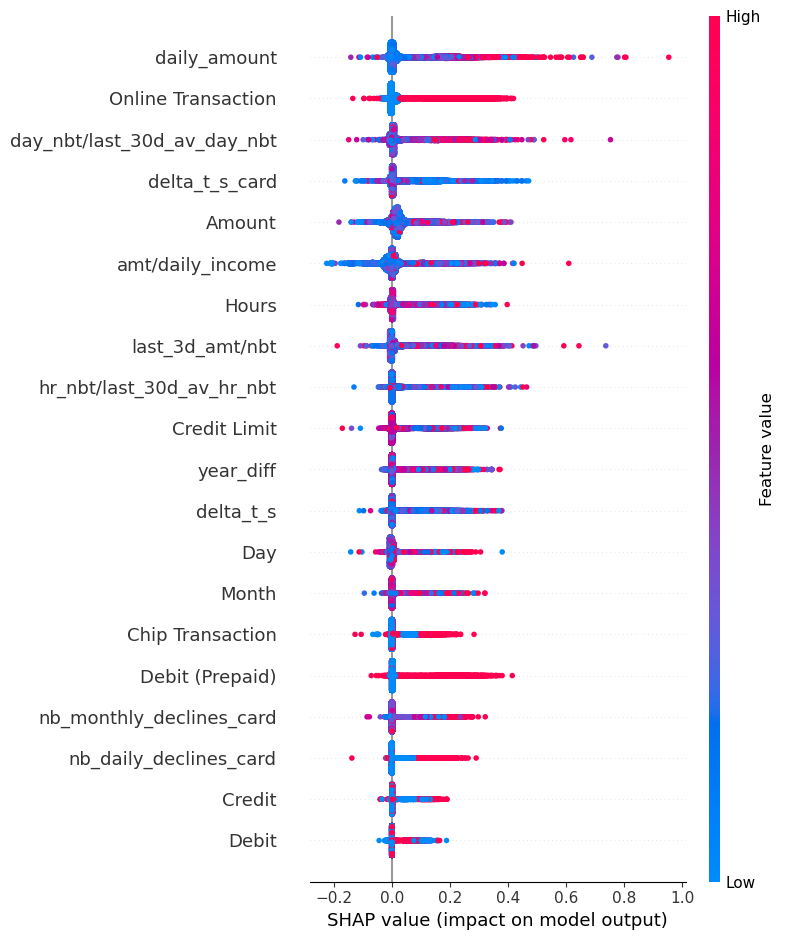

In [29]:
shap.summary_plot(shap_values[1], X_train_shap)

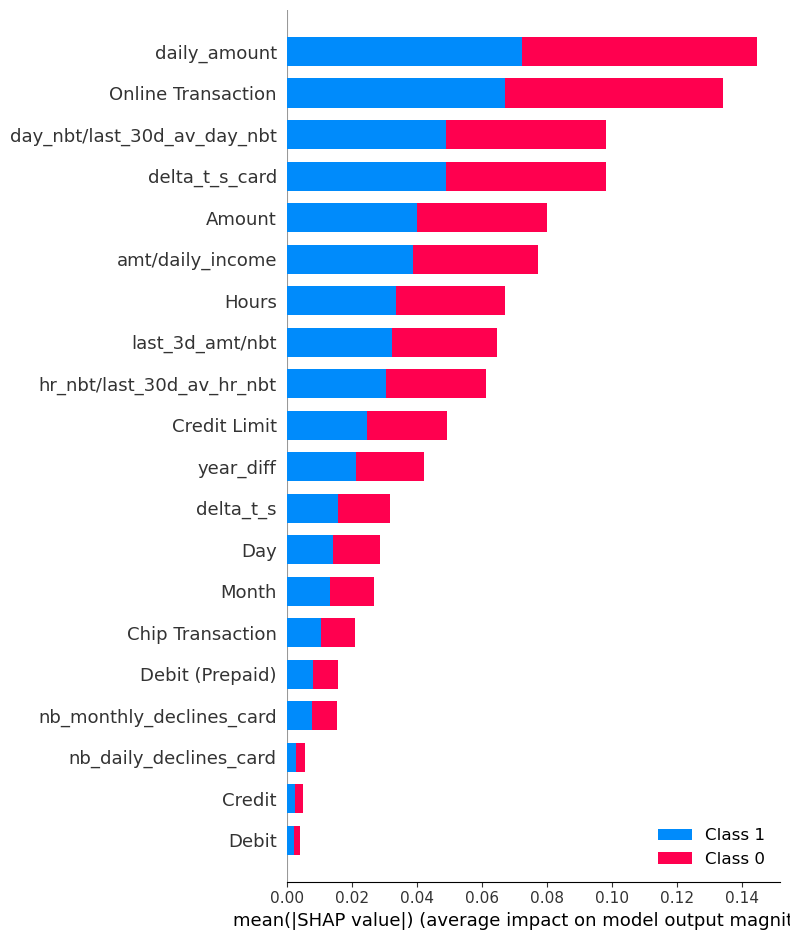

In [27]:
shap.summary_plot(shap_values, X_train_shap ,feature_names = X_train_shap.columns, plot_type="bar") 
# we can drop the 7 last ones : mastercard, amex, visa, discover, debit, credit, nb_daily_declines_card

### Tuning Hyperparameters

In [12]:
df_f1_score1 = pd.DataFrame(columns = ["class_weight_1", "f1score"])
for i in range(90, 100):
    dt = DecisionTreeClassifier(class_weight = {1:i/100,0:1-i/100}, random_state=42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    score = f1_score(y_pred, y_test)
    df_f1_score1.loc[len(df_f1_score1)] = [i/100, score]
df_f1_score1

,class_weight_1,f1score
0,0.90,0.285134
1,0.91,0.288949
2,0.92,0.282605
3,0.93,0.272276
4,0.94,0.256357
5,0.95,0.261198
6,0.96,0.258674
7,0.97,0.254433
8,0.98,0.236402
9,0.99,0.246922


Text(0.5, 1.0, 'f1-score according to class_weight (decision tree)')

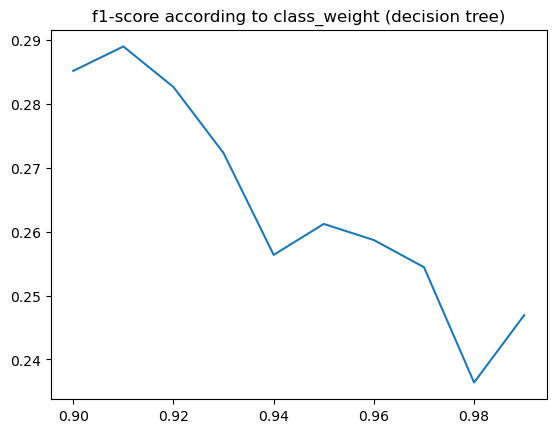

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(df_f1_score1.iloc[:,0].values, df_f1_score1.iloc[:,1].values)
plt.title('f1-score according to class_weight (decision tree)')

In [14]:
df_f1_score = pd.DataFrame(columns = ["min_samples_leaf", "f1score"])
for i in range(1, 100, 5):
    dt = DecisionTreeClassifier(class_weight = {1:df_f1_score1.iloc[df_f1_score1["f1score"].idxmax(), 0],0:1 - df_f1_score1.iloc[df_f1_score1["f1score"].idxmax(), 0]}, min_samples_leaf=i, random_state=42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    score = f1_score(y_pred, y_test)
    df_f1_score.loc[len(df_f1_score)] = [i, score]
df_f1_score    

,min_samples_leaf,f1score
0,1.0,0.288949
1,6.0,0.391284
2,11.0,0.422653
3,16.0,0.426115
4,21.0,0.440943
5,26.0,0.436834
6,31.0,0.446154
7,36.0,0.445321
8,41.0,0.447874
9,46.0,0.448683


Text(0.5, 1.0, 'f1-score according to min_samples_leaf (decision tree)')

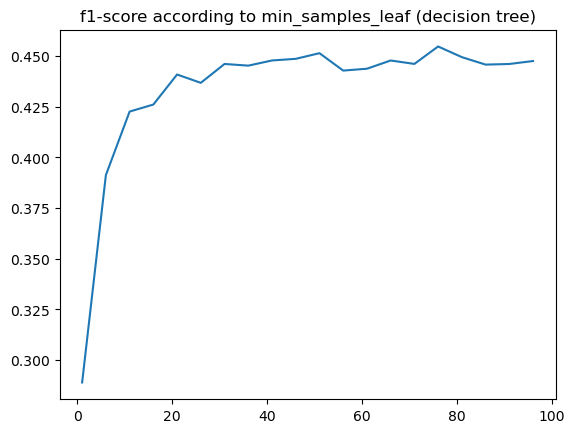

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(df_f1_score.iloc[:,0].values, df_f1_score.iloc[:,1].values)
plt.title('f1-score according to min_samples_leaf (decision tree)')

In [17]:
df_f1_score.iloc[df_f1_score["f1score"].idxmax(), 0]

76.0

In [18]:
df_f1_score2 = pd.DataFrame(columns = ["max_depth", "f1score"])
for i in range(1, 26):
    dt = DecisionTreeClassifier(class_weight = {1:df_f1_score1.iloc[df_f1_score1["f1score"].idxmax(), 0],0:1 - df_f1_score1.iloc[df_f1_score1["f1score"].idxmax(), 0]},
    min_samples_leaf=int(df_f1_score.iloc[df_f1_score["f1score"].idxmax(), 0]), max_depth=i, random_state= 42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    score = f1_score(y_pred, y_test)
    df_f1_score2.loc[len(df_f1_score2)] = [i, score]
df_f1_score2

,max_depth,f1score
0,1.0,0.000000
1,2.0,0.000000
2,3.0,0.283777
3,4.0,0.283777
4,5.0,0.321464
5,6.0,0.359058
6,7.0,0.381303
7,8.0,0.414085
8,9.0,0.427001
9,10.0,0.429765


Text(0.5, 1.0, 'f1-score according to max_depth (decision tree)')

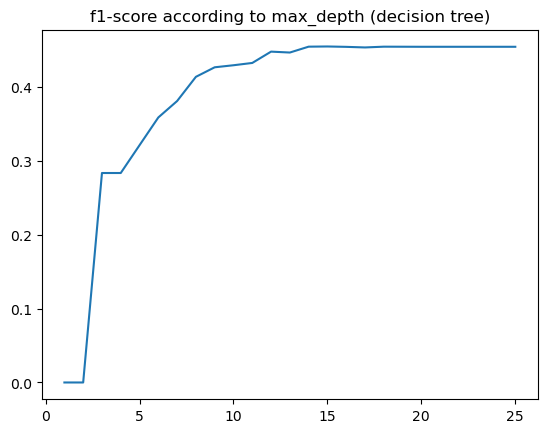

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(df_f1_score2.iloc[:,0].values, df_f1_score2.iloc[:,1].values)
plt.title('f1-score according to max_depth (decision tree)')

In [20]:
df_f1_score3 = pd.DataFrame(columns = ["max_features", "f1score"])
max_feat = [5, 10, 15, 20, 0.3, 0.5, 0.7, 0.9, "auto", "sqrt", "log2", None]
for i in range(len(max_feat)):
    dt = DecisionTreeClassifier(class_weight = {1:df_f1_score1.iloc[df_f1_score1["f1score"].idxmax(), 0],0:1 - df_f1_score1.iloc[df_f1_score1["f1score"].idxmax(), 0]},
    min_samples_leaf=int(df_f1_score.iloc[df_f1_score["f1score"].idxmax(), 0]),
    max_depth=int(df_f1_score2.iloc[df_f1_score2["f1score"].idxmax(), 0]), 
    max_features=max_feat[i], random_state= 42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    score = f1_score(y_pred, y_test)
    df_f1_score3.loc[len(df_f1_score3)] = [max_feat[i], score]
df_f1_score3

/opt/mamba/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


,max_features,f1score
0,5.0,0.387383
1,10.0,0.429167
2,15.0,0.437337
3,20.0,0.456034
4,0.3,0.423650
5,0.5,0.429167
6,0.7,0.444037
7,0.9,0.441550
8,auto,0.407030
9,sqrt,0.407030


### DT Model with optimal parameters

18


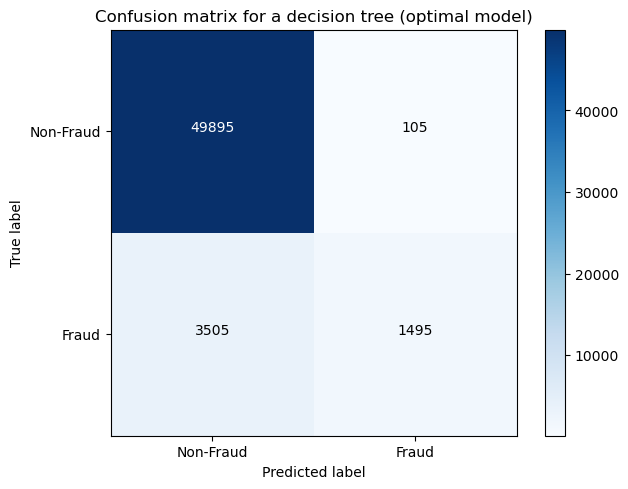

In [45]:
# Build and train model without any hyperparameters
decision_tree_opt = DecisionTreeClassifier(class_weight={1:0.91,0:0.09}, 
min_samples_leaf = 76, max_depth = 18, random_state=42)
decision_tree_opt.fit(X_train, y_train)
print(decision_tree_opt.tree_.max_depth)
# Apply model to validation data
y_pred_optdt = decision_tree_opt.predict(X_val)

cnf_matrix_optdtree = confusion_matrix(y_val, y_pred_optdt)
plt.figure()
plot_confusion_matrix(cnf_matrix_optdtree, title='Confusion matrix for a decision tree (optimal model)')
plt.show()

In [39]:
print('Classification metrics: \n', classification_report(y_val, y_pred_optdt))


Classification metrics: 
               precision    recall  f1-score   support

           0       0.93      1.00      0.97     50000
           1       0.93      0.30      0.45      5000

    accuracy                           0.93     55000
   macro avg       0.93      0.65      0.71     55000
weighted avg       0.93      0.93      0.92     55000



In [51]:
our_score(y_val, y_pred_optdt)

-74500

### RF Model with DT optimal parameters

Classification metrics: 
               precision    recall  f1-score   support

           0       0.93      1.00      0.96     50000
           1       0.97      0.20      0.34      5000

    accuracy                           0.93     55000
   macro avg       0.95      0.60      0.65     55000
weighted avg       0.93      0.93      0.90     55000



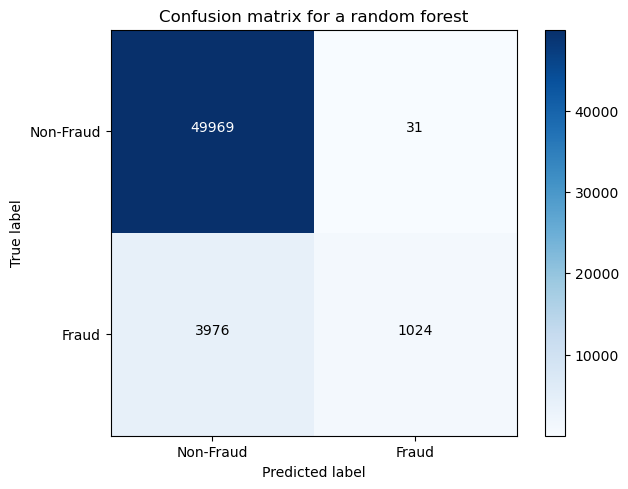

In [46]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight={1:0.91,0:0.09}, 
min_samples_leaf = 50, max_depth = 18, 
n_jobs = -1, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

# Evaluate model
print('Classification metrics: \n', classification_report(y_val, y_pred_rf))
cnf_matrix_rf = confusion_matrix(y_val, y_pred_rf)
plt.figure()
plot_confusion_matrix(cnf_matrix_rf, title='Confusion matrix for a random forest')
plt.show()

In [53]:
df_f1_score1 = pd.DataFrame(columns = ["class_weight_1", "f1score"])
for i in range(80, 100, 2):
    rf = RandomForestClassifier(class_weight = {1:i/100,0:1-i/100}, n_jobs = -1, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    score = f1_score(y_pred, y_val)
    df_f1_score1.loc[len(df_f1_score1)] = [i/100, score]
df_f1_score1

,class_weight_1,f1score
0,0.80,0.096670
1,0.82,0.096308
2,0.84,0.094131
3,0.86,0.099202
4,0.88,0.091586
5,0.90,0.087555
6,0.92,0.087937
7,0.94,0.085009
8,0.96,0.081703
9,0.98,0.077648


### Tuning hyperparameters

In [57]:
from sklearn.model_selection import GridSearchCV
parameters = {"class_weight" : [{1:i/100,0:1-i/100} for i in range(80, 100, 2)]}
clf = GridSearchCV(estimator = RandomForestClassifier(n_jobs = -1, random_state = 42), 
param_grid =  parameters, scoring = 'f1', n_jobs = -1, cv = 3, verbose = True)
clf_fit = clf.fit(X_train, y_train)
clf_fit.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
